  0%|          | 3/1000 [00:00<00:37, 26.91it/s]

y[0]とo[0] [ 0.58269293] [ 1.]
y[1]とo[1] [ 0.41730707] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5825653] [ 1.]
y[1]とo[1] [ 0.4174347] [ 0.]
y[0]とo[0] [ 0.58288166] [ 1.]
y[1]とo[1] [ 0.41711834] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58275462] [ 1.]
y[1]とo[1] [ 0.41724538] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5826272] [ 1.]
y[1]とo[1] [ 0.4173728] [ 0.]
y[0]とo[0] [ 0.58294367] [ 1.]
y[1]とo[1] [ 0.41705633] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58281685] [ 1.]
y[1]とo[1] [ 0.41718315] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58268967] [ 1.]
y[1]とo[1] [ 0.41731033] [ 0.]
y[0]とo[0] [ 0.58300623] [ 1.]
y[1]とo[1] [ 0.41699377] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58287966] [ 1.]
y[1]とo[1] [ 0.41712034] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.

  1%|▏         | 13/1000 [00:00<00:29, 34.02it/s]

 [ 0.5830718] [ 1.]
y[1]とo[1] [ 0.4169282] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58294575] [ 1.]
y[1]とo[1] [ 0.41705425] [ 0.]
y[0]とo[0] [ 0.58326259] [ 1.]
y[1]とo[1] [ 0.41673741] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5831372] [ 1.]
y[1]とo[1] [ 0.4168628] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58301149] [ 1.]
y[1]とo[1] [ 0.41698851] [ 0.]
y[0]とo[0] [ 0.58332837] [ 1.]
y[1]とo[1] [ 0.41667163] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58320334] [ 1.]
y[1]とo[1] [ 0.41679666] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58307798] [ 1.]
y[1]とo[1] [ 0.41692202] [ 0.]
y[0]とo[0] [ 0.5833949] [ 1.]
y[1]とo[1] [ 0.4166051] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58327024] [ 1.]
y[1]とo[1] [ 0.41672976] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [

  2%|▏         | 23/1000 [00:00<00:24, 39.56it/s]

[ 0.58376306] [ 1.]
y[1]とo[1] [ 0.41623694] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58364144] [ 1.]
y[1]とo[1] [ 0.41635856] [ 0.]
y[0]とo[0] [ 0.58395822] [ 1.]
y[1]とo[1] [ 0.41604178] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58383742] [ 1.]
y[1]とo[1] [ 0.41616258] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58371638] [ 1.]
y[1]とo[1] [ 0.41628362] [ 0.]
y[0]とo[0] [ 0.58403309] [ 1.]
y[1]とo[1] [ 0.41596691] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58391289] [ 1.]
y[1]とo[1] [ 0.41608711] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58379246] [ 1.]
y[1]とo[1] [ 0.41620754] [ 0.]
y[0]とo[0] [ 0.58410908] [ 1.]
y[1]とo[1] [ 0.41589092] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58398951] [ 1.]
y[1]とo[1] [ 0.41601049] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.422411

  3%|▎         | 33/1000 [00:00<00:23, 41.03it/s]


y[0]とo[0] [ 0.58456161] [ 1.]
y[1]とo[1] [ 0.41543839] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58444711] [ 1.]
y[1]とo[1] [ 0.41555289] [ 0.]
y[0]とo[0] [ 0.58476246] [ 1.]
y[1]とo[1] [ 0.41523754] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58464897] [ 1.]
y[1]とo[1] [ 0.41535103] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58453536] [ 1.]
y[1]とo[1] [ 0.41546464] [ 0.]
y[0]とo[0] [ 0.58485047] [ 1.]
y[1]とo[1] [ 0.41514953] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58473788] [ 1.]
y[1]とo[1] [ 0.41526212] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58462519] [ 1.]
y[1]とo[1] [ 0.41537481] [ 0.]
y[0]とo[0] [ 0.58494004] [ 1.]
y[1]とo[1] [ 0.41505996] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58482839] [ 1.]
y[1]とo[1] [ 0.41517161] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1]

  4%|▍         | 43/1000 [00:00<00:22, 43.04it/s]

y[0]とo[0] [ 0.58519992] [ 1.]
y[1]とo[1] [ 0.41480008] [ 0.]
y[0]とo[0] [ 0.58551271] [ 1.]
y[1]とo[1] [ 0.41448729] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58540741] [ 1.]
y[1]とo[1] [ 0.41459259] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58530211] [ 1.]
y[1]とo[1] [ 0.41469789] [ 0.]
y[0]とo[0] [ 0.58561446] [ 1.]
y[1]とo[1] [ 0.41438554] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58551035] [ 1.]
y[1]とo[1] [ 0.41448965] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58540625] [ 1.]
y[1]とo[1] [ 0.41459375] [ 0.]
y[0]とo[0] [ 0.58571814] [ 1.]
y[1]とo[1] [ 0.41428186] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58561525] [ 1.]
y[1]とo[1] [ 0.41438475] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58551239] [ 1.]
y[1]とo[1] [ 0.41448761] [ 0.]
y[0]とo[0] [ 0.58582379] [ 1.]
y[1]とo[1] 

  5%|▌         | 54/1000 [00:01<00:20, 45.12it/s]

 [ 0.58653032] [ 1.]
y[1]とo[1] [ 0.41346968] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58643879] [ 1.]
y[1]とo[1] [ 0.41356121] [ 0.]
y[0]とo[0] [ 0.58674492] [ 1.]
y[1]とo[1] [ 0.41325508] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5866548] [ 1.]
y[1]とo[1] [ 0.4133452] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58656486] [ 1.]
y[1]とo[1] [ 0.41343514] [ 0.]
y[0]とo[0] [ 0.58687014] [ 1.]
y[1]とo[1] [ 0.41312986] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58678164] [ 1.]
y[1]とo[1] [ 0.41321836] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58669334] [ 1.]
y[1]とo[1] [ 0.41330666] [ 0.]
y[0]とo[0] [ 0.58699772] [ 1.]
y[1]とo[1] [ 0.41300228] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58691088] [ 1.]
y[1]とo[1] [ 0.41308912] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.4224117

  6%|▋         | 64/1000 [00:01<00:20, 46.27it/s]

[ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58818539] [ 1.]
y[1]とo[1] [ 0.41181461] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58811562] [ 1.]
y[1]とo[1] [ 0.41188438] [ 0.]
y[0]とo[0] [ 0.58840763] [ 1.]
y[1]とo[1] [ 0.41159237] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58833954] [ 1.]
y[1]とo[1] [ 0.41166046] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58827183] [ 1.]
y[1]とo[1] [ 0.41172817] [ 0.]
y[0]とo[0] [ 0.58856219] [ 1.]
y[1]とo[1] [ 0.41143781] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58849617] [ 1.]
y[1]とo[1] [ 0.41150383] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58843056] [ 1.]
y[1]とo[1] [ 0.41156944] [ 0.]
y[0]とo[0] [ 0.58871918] [ 1.]
y[1]とo[1] [ 0.41128082] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58865527] [ 1.]
y[1]とo[1] [ 0.41134473] [ 0.]
y[0]

  8%|▊         | 76/1000 [00:01<00:18, 50.03it/s]


y[1]とo[1] [ 0.41039109] [ 0.]
y[0]とo[0] [ 0.58988251] [ 1.]
y[1]とo[1] [ 0.41011749] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58983407] [ 1.]
y[1]とo[1] [ 0.41016593] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58978613] [ 1.]
y[1]とo[1] [ 0.41021387] [ 0.]
y[0]とo[0] [ 0.59005711] [ 1.]
y[1]とo[1] [ 0.40994289] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59001095] [ 1.]
y[1]とo[1] [ 0.40998905] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5899653] [ 1.]
y[1]とo[1] [ 0.4100347] [ 0.]
y[0]とo[0] [ 0.59023353] [ 1.]
y[1]とo[1] [ 0.40976647] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59018966] [ 1.]
y[1]とo[1] [ 0.40981034] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59014632] [ 1.]
y[1]とo[1] [ 0.40985368] [ 0.]
y[0]とo[0] [ 0.59041166] [ 1.]
y[1]とo[1] [ 0.40958834] [ 0.]
y[0]とo[0] [

  9%|▊         | 87/1000 [00:01<00:19, 46.71it/s]

 [ 0.]
y[0]とo[0] [ 0.59206448] [ 1.]
y[1]とo[1] [ 0.40793552] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59204317] [ 1.]
y[1]とo[1] [ 0.40795683] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59202238] [ 1.]
y[1]とo[1] [ 0.40797762] [ 0.]
y[0]とo[0] [ 0.5922498] [ 1.]
y[1]とo[1] [ 0.4077502] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5922306] [ 1.]
y[1]とo[1] [ 0.4077694] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59221191] [ 1.]
y[1]とo[1] [ 0.40778809] [ 0.]
y[0]とo[0] [ 0.5924345] [ 1.]
y[1]とo[1] [ 0.4075655] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59241735] [ 1.]
y[1]とo[1] [ 0.40758265] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59240071] [ 1.]
y[1]とo[1] [ 0.40759929] [ 0.]
y[0]とo[0] [ 0.59261826] [ 1.]
y[1]とo[1] [ 0.40738174] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1]

 10%|▉         | 98/1000 [00:02<00:20, 44.30it/s]


y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59400764] [ 1.]
y[1]とo[1] [ 0.40599236] [ 0.]
y[0]とo[0] [ 0.59416946] [ 1.]
y[1]とo[1] [ 0.40583054] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59416874] [ 1.]
y[1]とo[1] [ 0.40583126] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5941683] [ 1.]
y[1]とo[1] [ 0.4058317] [ 0.]
y[0]とo[0] [ 0.5943227] [ 1.]
y[1]とo[1] [ 0.4056773] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59432307] [ 1.]
y[1]とo[1] [ 0.40567693] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59432368] [ 1.]
y[1]とo[1] [ 0.40567632] [ 0.]
y[0]とo[0] [ 0.59447042] [ 1.]
y[1]とo[1] [ 0.40552958] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59447174] [ 1.]
y[1]とo[1] [ 0.40552826] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59447326] [ 1.]
y[1]とo[1] [ 0

 10%|█         | 103/1000 [00:02<00:24, 36.99it/s]

 [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59530976] [ 1.]
y[1]とo[1] [ 0.40469024] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59531371] [ 1.]
y[1]とo[1] [ 0.40468629] [ 0.]
y[0]とo[0] [ 0.59539026] [ 1.]
y[1]とo[1] [ 0.40460974] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59539409] [ 1.]
y[1]とo[1] [ 0.40460591] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59539778] [ 1.]
y[1]とo[1] [ 0.40460222] [ 0.]
y[0]とo[0] [ 0.59546452] [ 1.]
y[1]とo[1] [ 0.40453548] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59546797] [ 1.]
y[1]とo[1] [ 0.40453203] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59547123] [ 1.]
y[1]とo[1] [ 0.40452877] [ 0.]
y[0]とo[0] [ 0.59552796] [ 1.]
y[1]とo[1] [ 0.40447204] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59553088] [ 1.]
y[1]とo[1] [ 0.40446912] [ 0.]
y[0

 11%|█         | 112/1000 [00:02<00:23, 38.01it/s]

y[1]とo[1] [ 0.40441992] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5955823] [ 1.]
y[1]とo[1] [ 0.4044177] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59558424] [ 1.]
y[1]とo[1] [ 0.40441576] [ 0.]
y[0]とo[0] [ 0.59562038] [ 1.]
y[1]とo[1] [ 0.40437962] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59562176] [ 1.]
y[1]とo[1] [ 0.40437824] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59562281] [ 1.]
y[1]とo[1] [ 0.40437719] [ 0.]
y[0]とo[0] [ 0.59564839] [ 1.]
y[1]とo[1] [ 0.40435161] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59564877] [ 1.]
y[1]とo[1] [ 0.40435123] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59564878] [ 1.]
y[1]とo[1] [ 0.40435122] [ 0.]
y[0]とo[0] [ 0.59566366] [ 1.]
y[1]とo[1] [ 0.40433634] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 

 12%|█▏        | 121/1000 [00:02<00:19, 45.91it/s]

 [ 0.404981] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59499944] [ 1.]
y[1]とo[1] [ 0.40500056] [ 0.]
y[0]とo[0] [ 0.59489243] [ 1.]
y[1]とo[1] [ 0.40510757] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59487135] [ 1.]
y[1]とo[1] [ 0.40512865] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59484953] [ 1.]
y[1]とo[1] [ 0.40515047] [ 0.]
y[0]とo[0] [ 0.59473167] [ 1.]
y[1]とo[1] [ 0.40526833] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5947083] [ 1.]
y[1]とo[1] [ 0.4052917] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5946842] [ 1.]
y[1]とo[1] [ 0.4053158] [ 0.]
y[0]とo[0] [ 0.59455563] [ 1.]
y[1]とo[1] [ 0.40544437] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59452997] [ 1.]
y[1]とo[1] [ 0.40547003] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59450356] [

 13%|█▎        | 132/1000 [00:03<00:23, 36.88it/s]

[ 0.]
y[0]とo[0] [ 0.59291487] [ 1.]
y[1]とo[1] [ 0.40708513] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59287381] [ 1.]
y[1]とo[1] [ 0.40712619] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59283207] [ 1.]
y[1]とo[1] [ 0.40716793] [ 0.]
y[0]とo[0] [ 0.59262636] [ 1.]
y[1]とo[1] [ 0.40737364] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59258335] [ 1.]
y[1]とo[1] [ 0.40741665] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59253969] [ 1.]
y[1]とo[1] [ 0.40746031] [ 0.]
y[0]とo[0] [ 0.59232573] [ 1.]
y[1]とo[1] [ 0.40767427] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59228087] [ 1.]
y[1]とo[1] [ 0.40771913] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59223539] [ 1.]
y[1]とo[1] [ 0.40776461] [ 0.]
y[0]とo[0] [ 0.59201356] [ 1.]
y[1]とo[1] [ 0.40798644] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]

 14%|█▍        | 142/1000 [00:03<00:22, 37.54it/s]

 [ 1.]
y[0]とo[0] [ 0.5906095] [ 1.]
y[1]とo[1] [ 0.4093905] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59055669] [ 1.]
y[1]とo[1] [ 0.40944331] [ 0.]
y[0]とo[0] [ 0.59030149] [ 1.]
y[1]とo[1] [ 0.40969851] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59024803] [ 1.]
y[1]とo[1] [ 0.40975197] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.59019415] [ 1.]
y[1]とo[1] [ 0.40980585] [ 0.]
y[0]とo[0] [ 0.58993352] [ 1.]
y[1]とo[1] [ 0.41006648] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58987909] [ 1.]
y[1]とo[1] [ 0.41012091] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58982429] [ 1.]
y[1]とo[1] [ 0.41017571] [ 0.]
y[0]とo[0] [ 0.58955865] [ 1.]
y[1]とo[1] [ 0.41044135] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5895034] [ 1.]
y[1]とo[1] [ 0.4104966] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[

 15%|█▌        | 150/1000 [00:03<00:19, 44.46it/s]

 [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58749045] [ 1.]
y[1]とo[1] [ 0.41250955] [ 0.]
y[0]とo[0] [ 0.58720332] [ 1.]
y[1]とo[1] [ 0.41279668] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58714605] [ 1.]
y[1]とo[1] [ 0.41285395] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58708866] [ 1.]
y[1]とo[1] [ 0.41291134] [ 0.]
y[0]とo[0] [ 0.58679928] [ 1.]
y[1]とo[1] [ 0.41320072] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58674213] [ 1.]
y[1]とo[1] [ 0.41325787] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58668489] [ 1.]
y[1]とo[1] [ 0.41331511] [ 0.]
y[0]とo[0] [ 0.58639362] [ 1.]
y[1]とo[1] [ 0.41360638] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58633671] [ 1.]
y[1]とo[1] [ 0.41366329] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58627973] [ 1.]
y[1]とo[1] [ 0.41372027] [ 0.]
y[0

 16%|█▌        | 161/1000 [00:03<00:22, 37.30it/s]

[ 0.4169003] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58304819] [ 1.]
y[1]とo[1] [ 0.41695181] [ 0.]
y[0]とo[0] [ 0.58275276] [ 1.]
y[1]とo[1] [ 0.41724724] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58270211] [ 1.]
y[1]とo[1] [ 0.41729789] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58265159] [ 1.]
y[1]とo[1] [ 0.41734841] [ 0.]
y[0]とo[0] [ 0.58235679] [ 1.]
y[1]とo[1] [ 0.41764321] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58230717] [ 1.]
y[1]とo[1] [ 0.41769283] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58225768] [ 1.]
y[1]とo[1] [ 0.41774232] [ 0.]
y[0]とo[0] [ 0.58196367] [ 1.]
y[1]とo[1] [ 0.41803633] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.58191511] [ 1.]
y[1]とo[1] [ 0.41808489] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5818666

 17%|█▋        | 170/1000 [00:04<00:23, 35.09it/s]


y[1]とo[1] [ 0.41999579] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57996149] [ 1.]
y[1]とo[1] [ 0.42003851] [ 0.]
y[0]とo[0] [ 0.57967446] [ 1.]
y[1]とo[1] [ 0.42032554] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57963276] [ 1.]
y[1]とo[1] [ 0.42036724] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57959122] [ 1.]
y[1]とo[1] [ 0.42040878] [ 0.]
y[0]とo[0] [ 0.57930558] [ 1.]
y[1]とo[1] [ 0.42069442] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57926506] [ 1.]
y[1]とo[1] [ 0.42073494] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57922469] [ 1.]
y[1]とo[1] [ 0.42077531] [ 0.]
y[0]とo[0] [ 0.57894048] [ 1.]
y[1]とo[1] [ 0.42105952] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57890113] [ 1.]
y[1]とo[1] [ 0.42109887] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0]

 18%|█▊        | 181/1000 [00:04<00:20, 39.39it/s]

 [ 0.57676354] [ 1.]
y[1]とo[1] [ 0.42323646] [ 0.]
y[0]とo[0] [ 0.57648923] [ 1.]
y[1]とo[1] [ 0.42351077] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57645774] [ 1.]
y[1]とo[1] [ 0.42354226] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57642637] [ 1.]
y[1]とo[1] [ 0.42357363] [ 0.]
y[0]とo[0] [ 0.57615335] [ 1.]
y[1]とo[1] [ 0.42384665] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5761229] [ 1.]
y[1]とo[1] [ 0.4238771] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57609257] [ 1.]
y[1]とo[1] [ 0.42390743] [ 0.]
y[0]とo[0] [ 0.57582079] [ 1.]
y[1]とo[1] [ 0.42417921] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57579137] [ 1.]
y[1]とo[1] [ 0.42420863] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57576205] [ 1.]
y[1]とo[1] [ 0.42423795] [ 0.]
y[0]とo[0] [ 0.57549144] [ 1.]
y[1]とo[1] [ 0.4245085

 19%|█▊        | 186/1000 [00:04<00:22, 36.23it/s]

 [ 0.5726304] [ 1.]
y[1]とo[1] [ 0.4273696] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57260984] [ 1.]
y[1]とo[1] [ 0.42739016] [ 0.]
y[0]とo[0] [ 0.57234655] [ 1.]
y[1]とo[1] [ 0.42765345] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57232672] [ 1.]
y[1]とo[1] [ 0.42767328] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57230691] [ 1.]
y[1]とo[1] [ 0.42769309] [ 0.]
y[0]とo[0] [ 0.57204382] [ 1.]
y[1]とo[1] [ 0.42795618] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57202471] [ 1.]
y[1]とo[1] [ 0.42797529] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57200562] [ 1.]
y[1]とo[1] [ 0.42799438] [ 0.]
y[0]とo[0] [ 0.57174263] [ 1.]
y[1]とo[1] [ 0.42825737] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57172423] [ 1.]
y[1]とo[1] [ 0.42827577] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.4224117

 19%|█▉        | 194/1000 [00:04<00:24, 32.32it/s]


y[1]とo[1] [ 0.42888981] [ 0.]
y[0]とo[0] [ 0.57084684] [ 1.]
y[1]とo[1] [ 0.42915316] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57083044] [ 1.]
y[1]とo[1] [ 0.42916956] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57081402] [ 1.]
y[1]とo[1] [ 0.42918598] [ 0.]
y[0]とo[0] [ 0.57055033] [ 1.]
y[1]とo[1] [ 0.42944967] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57053456] [ 1.]
y[1]とo[1] [ 0.42946544] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57051877] [ 1.]
y[1]とo[1] [ 0.42948123] [ 0.]
y[0]とo[0] [ 0.57025462] [ 1.]
y[1]とo[1] [ 0.42974538] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57023947] [ 1.]
y[1]とo[1] [ 0.42976053] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.57022428] [ 1.]
y[1]とo[1] [ 0.42977572] [ 0.]
y[0]とo[0] [ 0.56995956] [ 1.]
y[1]とo[1] [ 0.43004044] [ 0.]
y[0]とo[0]

 20%|██        | 202/1000 [00:04<00:23, 33.52it/s]

 [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56875847] [ 1.]
y[1]とo[1] [ 0.43124153] [ 0.]
y[0]とo[0] [ 0.56848913] [ 1.]
y[1]とo[1] [ 0.43151087] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56847743] [ 1.]
y[1]とo[1] [ 0.43152257] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56846568] [ 1.]
y[1]とo[1] [ 0.43153432] [ 0.]
y[0]とo[0] [ 0.56819506] [ 1.]
y[1]とo[1] [ 0.43180494] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56818392] [ 1.]
y[1]とo[1] [ 0.43181608] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56817272] [ 1.]
y[1]とo[1] [ 0.43182728] [ 0.]
y[0]とo[0] [ 0.5679007] [ 1.]
y[1]とo[1] [ 0.4320993] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56789011] [ 1.]
y[1]とo[1] [ 0.43210989] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56787946] [ 1.]
y[1]とo[1] [ 0.4321205

 21%|██        | 210/1000 [00:05<00:23, 33.02it/s]

[ 0.]
y[0]とo[0] [ 0.56671798] [ 1.]
y[1]とo[1] [ 0.43328202] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56670963] [ 1.]
y[1]とo[1] [ 0.43329037] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5667012] [ 1.]
y[1]とo[1] [ 0.4332988] [ 0.]
y[0]とo[0] [ 0.56642043] [ 1.]
y[1]とo[1] [ 0.43357957] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56641266] [ 1.]
y[1]とo[1] [ 0.43358734] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5664048] [ 1.]
y[1]とo[1] [ 0.4335952] [ 0.]
y[0]とo[0] [ 0.56612193] [ 1.]
y[1]とo[1] [ 0.43387807] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56611475] [ 1.]
y[1]とo[1] [ 0.43388525] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56610749] [ 1.]
y[1]とo[1] [ 0.43389251] [ 0.]
y[0]とo[0] [ 0.5658224] [ 1.]
y[1]とo[1] [ 0.4341776] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] 

 21%|██▏       | 214/1000 [00:05<00:23, 33.36it/s]

[ 0.56460849] [ 1.]
y[1]とo[1] [ 0.43539151] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56460447] [ 1.]
y[1]とo[1] [ 0.43539553] [ 0.]
y[0]とo[0] [ 0.56430665] [ 1.]
y[1]とo[1] [ 0.43569335] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56430345] [ 1.]
y[1]とo[1] [ 0.43569655] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56430016] [ 1.]
y[1]とo[1] [ 0.43569984] [ 0.]
y[0]とo[0] [ 0.56399947] [ 1.]
y[1]とo[1] [ 0.43600053] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56399703] [ 1.]
y[1]とo[1] [ 0.43600297] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56399451] [ 1.]
y[1]とo[1] [ 0.43600549] [ 0.]
y[0]とo[0] [ 0.56369086] [ 1.]
y[1]とo[1] [ 0.43630914] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56368923] [ 1.]
y[1]とo[1] [ 0.43631077] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.422411

 22%|██▏       | 223/1000 [00:05<00:22, 34.41it/s]

[ 0.5630694] [ 1.]
y[1]とo[1] [ 0.4369306] [ 0.]
y[0]とo[0] [ 0.56275629] [ 1.]
y[1]とo[1] [ 0.43724371] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56275734] [ 1.]
y[1]とo[1] [ 0.43724266] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5627583] [ 1.]
y[1]とo[1] [ 0.4372417] [ 0.]
y[0]とo[0] [ 0.56244187] [ 1.]
y[1]とo[1] [ 0.43755813] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56244392] [ 1.]
y[1]とo[1] [ 0.43755608] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56244588] [ 1.]
y[1]とo[1] [ 0.43755412] [ 0.]
y[0]とo[0] [ 0.56212604] [ 1.]
y[1]とo[1] [ 0.43787396] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56212914] [ 1.]
y[1]とo[1] [ 0.43787086] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.56213216] [ 1.]
y[1]とo[1] [ 0.43786784] [ 0.]
y[0]とo[0] [ 0.56180885] [ 1.]
y[1]とo[1] [ 0.43819115] 

 24%|██▎       | 235/1000 [00:05<00:20, 37.79it/s]

 [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55989391] [ 1.]
y[1]とo[1] [ 0.44010609] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55990638] [ 1.]
y[1]とo[1] [ 0.44009362] [ 0.]
y[0]とo[0] [ 0.55955715] [ 1.]
y[1]とo[1] [ 0.44044285] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55957138] [ 1.]
y[1]とo[1] [ 0.44042862] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55958554] [ 1.]
y[1]とo[1] [ 0.44041446] [ 0.]
y[0]とo[0] [ 0.55923247] [ 1.]
y[1]とo[1] [ 0.44076753] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5592485] [ 1.]
y[1]とo[1] [ 0.4407515] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55926446] [ 1.]
y[1]とo[1] [ 0.44073554] [ 0.]
y[0]とo[0] [ 0.55890754] [ 1.]
y[1]とo[1] [ 0.44109246] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55892546] [ 1.]
y[1]と

 24%|██▍       | 245/1000 [00:06<00:17, 41.96it/s]


y[1]とo[1] [ 0.44394779] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55609266] [ 1.]
y[1]とo[1] [ 0.44390734] [ 0.]
y[0]とo[0] [ 0.55569843] [ 1.]
y[1]とo[1] [ 0.44430157] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55574212] [ 1.]
y[1]とo[1] [ 0.44425788] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55578573] [ 1.]
y[1]とo[1] [ 0.44421427] [ 0.]
y[0]とo[0] [ 0.55538809] [ 1.]
y[1]とo[1] [ 0.44461191] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55543509] [ 1.]
y[1]とo[1] [ 0.44456491] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55548199] [ 1.]
y[1]とo[1] [ 0.44451801] [ 0.]
y[0]とo[0] [ 0.55508102] [ 1.]
y[1]とo[1] [ 0.44491898] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55513146] [ 1.]
y[1]とo[1] [ 0.44486854] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0]

 26%|██▌       | 259/1000 [00:06<00:15, 48.61it/s]

y[1]とo[1] [ 0.44659825] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55347533] [ 1.]
y[1]とo[1] [ 0.44652467] [ 0.]
y[0]とo[0] [ 0.55305402] [ 1.]
y[1]とo[1] [ 0.44694598] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55313216] [ 1.]
y[1]とo[1] [ 0.44686784] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55321001] [ 1.]
y[1]とo[1] [ 0.44678999] [ 0.]
y[0]とo[0] [ 0.55278626] [ 1.]
y[1]とo[1] [ 0.44721374] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55286881] [ 1.]
y[1]とo[1] [ 0.44713119] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55295104] [ 1.]
y[1]とo[1] [ 0.44704896] [ 0.]
y[0]とo[0] [ 0.55252497] [ 1.]
y[1]とo[1] [ 0.44747503] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55261203] [ 1.]
y[1]とo[1] [ 0.44738797] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] 

 27%|██▋       | 273/1000 [00:06<00:13, 52.00it/s]

 [ 1.]
y[1]とo[1] [ 0.45001632] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55012874] [ 1.]
y[1]とo[1] [ 0.44987126] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55027259] [ 1.]
y[1]とo[1] [ 0.44972741] [ 0.]
y[0]とo[0] [ 0.54982605] [ 1.]
y[1]とo[1] [ 0.45017395] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54997594] [ 1.]
y[1]とo[1] [ 0.45002406] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55012452] [ 1.]
y[1]とo[1] [ 0.44987548] [ 0.]
y[0]とo[0] [ 0.54967698] [ 1.]
y[1]とo[1] [ 0.45032302] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54983165] [ 1.]
y[1]とo[1] [ 0.45016835] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54998493] [ 1.]
y[1]とo[1] [ 0.45001507] [ 0.]
y[0]とo[0] [ 0.54953644] [ 1.]
y[1]とo[1] [ 0.45046356] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0

 28%|██▊       | 279/1000 [00:06<00:15, 46.30it/s]

 [ 0.54888142] [ 1.]
y[1]とo[1] [ 0.45111858] [ 0.]
y[0]とo[0] [ 0.5484228] [ 1.]
y[1]とo[1] [ 0.4515772] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54863505] [ 1.]
y[1]とo[1] [ 0.45136495] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54884446] [ 1.]
y[1]とo[1] [ 0.45115554] [ 0.]
y[0]とo[0] [ 0.54838509] [ 1.]
y[1]とo[1] [ 0.45161491] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5486006] [ 1.]
y[1]とo[1] [ 0.4513994] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54881317] [ 1.]
y[1]とo[1] [ 0.45118683] [ 0.]
y[0]とo[0] [ 0.54835305] [ 1.]
y[1]とo[1] [ 0.45164695] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54857169] [ 1.]
y[1]とo[1] [ 0.45142831] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54878729] [ 1.]
y[1]とo[1] [ 0.45121271] [ 0.]
y[0]とo[0] [ 0.54832641] [ 1.]
y[1]とo[1] [ 0.45167359]

 29%|██▉       | 290/1000 [00:06<00:17, 40.24it/s]

 [ 0.45124922] [ 0.]
y[0]とo[0] [ 0.54828834] [ 1.]
y[1]とo[1] [ 0.45171166] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54851564] [ 1.]
y[1]とo[1] [ 0.45148436] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54873963] [ 1.]
y[1]とo[1] [ 0.45126037] [ 0.]
y[0]とo[0] [ 0.5482764] [ 1.]
y[1]とo[1] [ 0.4517236] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54850635] [ 1.]
y[1]とo[1] [ 0.45149365] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54873289] [ 1.]
y[1]とo[1] [ 0.45126711] [ 0.]
y[0]とo[0] [ 0.54826886] [ 1.]
y[1]とo[1] [ 0.45173114] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54850133] [ 1.]
y[1]とo[1] [ 0.45149867] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54873032] [ 1.]
y[1]とo[1] [ 0.45126968] [ 0.]
y[0]とo[0] [ 0.54826548] [ 1.]
y[1]とo[1] [ 0.45173452] [ 0.]
y[0]とo[0] [ 0.5775882

 30%|███       | 300/1000 [00:07<00:18, 38.42it/s]

y[1]とo[1] [ 0.45143355] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54880948] [ 1.]
y[1]とo[1] [ 0.45119052] [ 0.]
y[0]とo[0] [ 0.54833873] [ 1.]
y[1]とo[1] [ 0.45166127] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54858746] [ 1.]
y[1]とo[1] [ 0.45141254] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5488321] [ 1.]
y[1]とo[1] [ 0.4511679] [ 0.]
y[0]とo[0] [ 0.54836047] [ 1.]
y[1]とo[1] [ 0.45163953] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54861078] [ 1.]
y[1]とo[1] [ 0.45138922] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54885694] [ 1.]
y[1]とo[1] [ 0.45114306] [ 0.]
y[0]とo[0] [ 0.54838444] [ 1.]
y[1]とo[1] [ 0.45161556] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54863625] [ 1.]
y[1]とo[1] [ 0.45136375] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 

 30%|███       | 305/1000 [00:07<00:19, 36.36it/s]

[ 1.]
y[1]とo[1] [ 0.45113928] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5491162] [ 1.]
y[1]とo[1] [ 0.4508838] [ 0.]
y[0]とo[0] [ 0.54863671] [ 1.]
y[1]とo[1] [ 0.45136329] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54889766] [ 1.]
y[1]とo[1] [ 0.45110234] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54915399] [ 1.]
y[1]とo[1] [ 0.45084601] [ 0.]
y[0]とo[0] [ 0.54867364] [ 1.]
y[1]とo[1] [ 0.45132636] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54893543] [ 1.]
y[1]とo[1] [ 0.45106457] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54919256] [ 1.]
y[1]とo[1] [ 0.45080744] [ 0.]
y[0]とo[0] [ 0.54871135] [ 1.]
y[1]とo[1] [ 0.45128865] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54897393] [ 1.]
y[1]とo[1] [ 0.45102607] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo

 31%|███▏      | 314/1000 [00:07<00:20, 33.83it/s]

 [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54935259] [ 1.]
y[1]とo[1] [ 0.45064741] [ 0.]
y[0]とo[0] [ 0.54886801] [ 1.]
y[1]とo[1] [ 0.45113199] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5491332] [ 1.]
y[1]とo[1] [ 0.4508668] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54939356] [ 1.]
y[1]とo[1] [ 0.45060644] [ 0.]
y[0]とo[0] [ 0.54890817] [ 1.]
y[1]とo[1] [ 0.45109183] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5491739] [ 1.]
y[1]とo[1] [ 0.4508261] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54943477] [ 1.]
y[1]とo[1] [ 0.45056523] [ 0.]
y[0]とo[0] [ 0.54894857] [ 1.]
y[1]とo[1] [ 0.45105143] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54921479] [ 1.]
y[1]とo[1] [ 0.45078521] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54947613] [ 1.]
y[1]とo[1] [ 0.45052387] [ 0.]
y[0]とo[

 32%|███▏      | 322/1000 [00:07<00:19, 35.50it/s]

y[0]とo[0] [ 0.54964178] [ 1.]
y[1]とo[1] [ 0.45035822] [ 0.]
y[0]とo[0] [ 0.54915166] [ 1.]
y[1]とo[1] [ 0.45084834] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54941982] [ 1.]
y[1]とo[1] [ 0.45058018] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54968297] [ 1.]
y[1]とo[1] [ 0.45031703] [ 0.]
y[0]とo[0] [ 0.5491921] [ 1.]
y[1]とo[1] [ 0.4508079] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54946054] [ 1.]
y[1]とo[1] [ 0.45053946] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54972397] [ 1.]
y[1]とo[1] [ 0.45027603] [ 0.]
y[0]とo[0] [ 0.54923235] [ 1.]
y[1]とo[1] [ 0.45076765] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54950106] [ 1.]
y[1]とo[1] [ 0.45049894] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54976473] [ 1.]
y[1]とo[1] [ 0.45023527] [ 0.]
y[0]とo[0] [ 0.54927238] [ 1.]
y[1]とo[1] [ 

 33%|███▎      | 331/1000 [00:08<00:18, 36.53it/s]

 [ 0.54981345] [ 1.]
y[1]とo[1] [ 0.45018655] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5500783] [ 1.]
y[1]とo[1] [ 0.4499217] [ 0.]
y[0]とo[0] [ 0.54958053] [ 1.]
y[1]とo[1] [ 0.45041947] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54985061] [ 1.]
y[1]とo[1] [ 0.45014939] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55011553] [ 1.]
y[1]とo[1] [ 0.44988447] [ 0.]
y[0]とo[0] [ 0.54961713] [ 1.]
y[1]とo[1] [ 0.45038287] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54988728] [ 1.]
y[1]とo[1] [ 0.45011272] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55015225] [ 1.]
y[1]とo[1] [ 0.44984775] [ 0.]
y[0]とo[0] [ 0.54965324] [ 1.]
y[1]とo[1] [ 0.45034676] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.54992344] [ 1.]
y[1]とo[1] [ 0.45007656] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.4224117

 34%|███▍      | 343/1000 [00:08<00:14, 44.69it/s]

 [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55036134] [ 1.]
y[1]とo[1] [ 0.44963866] [ 0.]
y[0]とo[0] [ 0.5498589] [ 1.]
y[1]とo[1] [ 0.4501411] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55012918] [ 1.]
y[1]とo[1] [ 0.44987082] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55039423] [ 1.]
y[1]とo[1] [ 0.44960577] [ 0.]
y[0]とo[0] [ 0.54989125] [ 1.]
y[1]とo[1] [ 0.45010875] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55016152] [ 1.]
y[1]とo[1] [ 0.44983848] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55042655] [ 1.]
y[1]とo[1] [ 0.44957345] [ 0.]
y[0]とo[0] [ 0.54992305] [ 1.]
y[1]とo[1] [ 0.45007695] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55019329] [ 1.]
y[1]とo[1] [ 0.44980671] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55045829] [ 1.]
y[1]と

 35%|███▌      | 353/1000 [00:08<00:14, 43.31it/s]


y[0]とo[0] [ 0.55020987] [ 1.]
y[1]とo[1] [ 0.44979013] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55047958] [ 1.]
y[1]とo[1] [ 0.44952042] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55074402] [ 1.]
y[1]とo[1] [ 0.44925598] [ 0.]
y[0]とo[0] [ 0.55023547] [ 1.]
y[1]とo[1] [ 0.44976453] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55050511] [ 1.]
y[1]とo[1] [ 0.44949489] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55076948] [ 1.]
y[1]とo[1] [ 0.44923052] [ 0.]
y[0]とo[0] [ 0.55026053] [ 1.]
y[1]とo[1] [ 0.44973947] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5505301] [ 1.]
y[1]とo[1] [ 0.4494699] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55079439] [ 1.]
y[1]とo[1] [ 0.44920561] [ 0.]
y[0]とo[0] [ 0.55028505] [ 1.]
y[1]とo[1] [ 0.44971495] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [

 36%|███▋      | 363/1000 [00:08<00:13, 45.92it/s]

 [ 0.44955788] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55071105] [ 1.]
y[1]とo[1] [ 0.44928895] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5509747] [ 1.]
y[1]とo[1] [ 0.4490253] [ 0.]
y[0]とo[0] [ 0.55046256] [ 1.]
y[1]とo[1] [ 0.44953744] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55073141] [ 1.]
y[1]とo[1] [ 0.44926859] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55099497] [ 1.]
y[1]とo[1] [ 0.44900503] [ 0.]
y[0]とo[0] [ 0.55048252] [ 1.]
y[1]とo[1] [ 0.44951748] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55075128] [ 1.]
y[1]とo[1] [ 0.44924872] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55101477] [ 1.]
y[1]とo[1] [ 0.44898523] [ 0.]
y[0]とo[0] [ 0.550502] [ 1.]
y[1]とo[1] [ 0.449498] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55077069] [

 38%|███▊      | 375/1000 [00:08<00:12, 51.73it/s]

[ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55117269] [ 1.]
y[1]とo[1] [ 0.44882731] [ 0.]
y[0]とo[0] [ 0.55065749] [ 1.]
y[1]とo[1] [ 0.44934251] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55092546] [ 1.]
y[1]とo[1] [ 0.44907454] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55118814] [ 1.]
y[1]とo[1] [ 0.44881186] [ 0.]
y[0]とo[0] [ 0.5506727] [ 1.]
y[1]とo[1] [ 0.4493273] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55094059] [ 1.]
y[1]とo[1] [ 0.44905941] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5512032] [ 1.]
y[1]とo[1] [ 0.4487968] [ 0.]
y[0]とo[0] [ 0.55068753] [ 1.]
y[1]とo[1] [ 0.44931247] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55095534] [ 1.]
y[1]とo[1] [ 0.44904466] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55121787] [ 1.]
y[1]とo[1] [ 0.44878213] 

 39%|███▊      | 387/1000 [00:09<00:13, 46.99it/s]

 [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55131057] [ 1.]
y[1]とo[1] [ 0.44868943] [ 0.]
y[0]とo[0] [ 0.55079326] [ 1.]
y[1]とo[1] [ 0.44920674] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5510605] [ 1.]
y[1]とo[1] [ 0.4489395] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55132247] [ 1.]
y[1]とo[1] [ 0.44867753] [ 0.]
y[0]とo[0] [ 0.55080498] [ 1.]
y[1]とo[1] [ 0.44919502] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55107215] [ 1.]
y[1]とo[1] [ 0.44892785] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55133405] [ 1.]
y[1]とo[1] [ 0.44866595] [ 0.]
y[0]とo[0] [ 0.55081638] [ 1.]
y[1]とo[1] [ 0.44918362] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5510835] [ 1.]
y[1]とo[1] [ 0.4489165] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55134533] [ 1.]
y[1]とo[1] [ 0.44865467] [ 0.]
y[0]とo[0] [ 0.55082749]

 40%|███▉      | 398/1000 [00:09<00:12, 48.75it/s]

[ 1.]
y[1]とo[1] [ 0.44882712] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55143419] [ 1.]
y[1]とo[1] [ 0.44856581] [ 0.]
y[0]とo[0] [ 0.55091499] [ 1.]
y[1]とo[1] [ 0.44908501] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55118152] [ 1.]
y[1]とo[1] [ 0.44881848] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55144277] [ 1.]
y[1]とo[1] [ 0.44855723] [ 0.]
y[0]とo[0] [ 0.55092344] [ 1.]
y[1]とo[1] [ 0.44907656] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55118992] [ 1.]
y[1]とo[1] [ 0.44881008] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55145113] [ 1.]
y[1]とo[1] [ 0.44854887] [ 0.]
y[0]とo[0] [ 0.55093167] [ 1.]
y[1]とo[1] [ 0.44906833] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5511981] [ 1.]
y[1]とo[1] [ 0.4488019] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo

 41%|████      | 411/1000 [00:09<00:11, 51.89it/s]

[ 1.]
y[1]とo[1] [ 0.44900381] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55126221] [ 1.]
y[1]とo[1] [ 0.44873779] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55152296] [ 1.]
y[1]とo[1] [ 0.44847704] [ 0.]
y[0]とo[0] [ 0.5510024] [ 1.]
y[1]とo[1] [ 0.4489976] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55126838] [ 1.]
y[1]とo[1] [ 0.44873162] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55152909] [ 1.]
y[1]とo[1] [ 0.44847091] [ 0.]
y[0]とo[0] [ 0.55100844] [ 1.]
y[1]とo[1] [ 0.44899156] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55127438] [ 1.]
y[1]とo[1] [ 0.44872562] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55153505] [ 1.]
y[1]とo[1] [ 0.44846495] [ 0.]
y[0]とo[0] [ 0.5510143] [ 1.]
y[1]とo[1] [ 0.4489857] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0

 42%|████▏     | 423/1000 [00:09<00:11, 51.74it/s]

[ 0.55106885] [ 1.]
y[1]とo[1] [ 0.44893115] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55133439] [ 1.]
y[1]とo[1] [ 0.44866561] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55159466] [ 1.]
y[1]とo[1] [ 0.44840534] [ 0.]
y[0]とo[0] [ 0.55107301] [ 1.]
y[1]とo[1] [ 0.44892699] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55133852] [ 1.]
y[1]とo[1] [ 0.44866148] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55159876] [ 1.]
y[1]とo[1] [ 0.44840124] [ 0.]
y[0]とo[0] [ 0.55107704] [ 1.]
y[1]とo[1] [ 0.44892296] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55134252] [ 1.]
y[1]とo[1] [ 0.44865748] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55160274] [ 1.]
y[1]とo[1] [ 0.44839726] [ 0.]
y[0]とo[0] [ 0.55108096] [ 1.]
y[1]とo[1] [ 0.44891904] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.422411

 44%|████▎     | 436/1000 [00:10<00:10, 55.25it/s]

[ 1.]
y[1]とo[1] [ 0.44836624] [ 0.]
y[0]とo[0] [ 0.55111151] [ 1.]
y[1]とo[1] [ 0.44888849] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55137675] [ 1.]
y[1]とo[1] [ 0.44862325] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55163673] [ 1.]
y[1]とo[1] [ 0.44836327] [ 0.]
y[0]とo[0] [ 0.55111443] [ 1.]
y[1]とo[1] [ 0.44888557] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55137965] [ 1.]
y[1]とo[1] [ 0.44862035] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55163961] [ 1.]
y[1]とo[1] [ 0.44836039] [ 0.]
y[0]とo[0] [ 0.55111726] [ 1.]
y[1]とo[1] [ 0.44888274] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55138247] [ 1.]
y[1]とo[1] [ 0.44861753] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55164241] [ 1.]
y[1]とo[1] [ 0.44835759] [ 0.]
y[0]とo[0] [ 0.55112002] [ 1.]
y[1]とo[1] [ 0.44887998] [ 0.]
y[0]

 45%|████▌     | 450/1000 [00:10<00:09, 59.21it/s]

[ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55140224] [ 1.]
y[1]とo[1] [ 0.44859776] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55166204] [ 1.]
y[1]とo[1] [ 0.44833796] [ 0.]
y[0]とo[0] [ 0.55113935] [ 1.]
y[1]とo[1] [ 0.44886065] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55140439] [ 1.]
y[1]とo[1] [ 0.44859561] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55166418] [ 1.]
y[1]とo[1] [ 0.44833582] [ 0.]
y[0]とo[0] [ 0.55114146] [ 1.]
y[1]とo[1] [ 0.44885854] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55140649] [ 1.]
y[1]とo[1] [ 0.44859351] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55166626] [ 1.]
y[1]とo[1] [ 0.44833374] [ 0.]
y[0]とo[0] [ 0.5511435] [ 1.]
y[1]とo[1] [ 0.4488565] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55140852] [ 1.]
y[1]とo

 46%|████▋     | 465/1000 [00:10<00:08, 60.86it/s]


y[0]とo[0] [ 0.55142729] [ 1.]
y[1]とo[1] [ 0.44857271] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55168691] [ 1.]
y[1]とo[1] [ 0.44831309] [ 0.]
y[0]とo[0] [ 0.55116383] [ 1.]
y[1]とo[1] [ 0.44883617] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5514287] [ 1.]
y[1]とo[1] [ 0.4485713] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55168831] [ 1.]
y[1]とo[1] [ 0.44831169] [ 0.]
y[0]とo[0] [ 0.55116522] [ 1.]
y[1]とo[1] [ 0.44883478] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55143008] [ 1.]
y[1]とo[1] [ 0.44856992] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55168968] [ 1.]
y[1]とo[1] [ 0.44831032] [ 0.]
y[0]とo[0] [ 0.55116657] [ 1.]
y[1]とo[1] [ 0.44883343] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55143142] [ 1.]
y[1]とo[1] [ 0.44856858] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [

 48%|████▊     | 478/1000 [00:10<00:10, 51.85it/s]

y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55170592] [ 1.]
y[1]とo[1] [ 0.44829408] [ 0.]
y[0]とo[0] [ 0.55118255] [ 1.]
y[1]とo[1] [ 0.44881745] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55144729] [ 1.]
y[1]とo[1] [ 0.44855271] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55170676] [ 1.]
y[1]とo[1] [ 0.44829324] [ 0.]
y[0]とo[0] [ 0.55118338] [ 1.]
y[1]とo[1] [ 0.44881662] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55144811] [ 1.]
y[1]とo[1] [ 0.44855189] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55170758] [ 1.]
y[1]とo[1] [ 0.44829242] [ 0.]
y[0]とo[0] [ 0.55118419] [ 1.]
y[1]とo[1] [ 0.44881581] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55144891] [ 1.]
y[1]とo[1] [ 0.44855109] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55170837] [ 1.]
y[1]とo[1] [ 0.44829163] [ 0.]
y[0]とo[0] 

 48%|████▊     | 484/1000 [00:11<00:10, 50.57it/s]

 [ 1.]
y[1]とo[1] [ 0.44854613] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517133] [ 1.]
y[1]とo[1] [ 0.4482867] [ 0.]
y[0]とo[0] [ 0.55118982] [ 1.]
y[1]とo[1] [ 0.44881018] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5514545] [ 1.]
y[1]とo[1] [ 0.4485455] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55171392] [ 1.]
y[1]とo[1] [ 0.44828608] [ 0.]
y[0]とo[0] [ 0.55119043] [ 1.]
y[1]とo[1] [ 0.44880957] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5514551] [ 1.]
y[1]とo[1] [ 0.4485449] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55171452] [ 1.]
y[1]とo[1] [ 0.44828548] [ 0.]
y[0]とo[0] [ 0.55119102] [ 1.]
y[1]とo[1] [ 0.44880898] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55145569] [ 1.]
y[1]とo[1] [ 0.44854431] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0]

 50%|████▉     | 496/1000 [00:11<00:10, 50.24it/s]

 [ 0.44854112] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55171826] [ 1.]
y[1]とo[1] [ 0.44828174] [ 0.]
y[0]とo[0] [ 0.55119471] [ 1.]
y[1]とo[1] [ 0.44880529] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55145935] [ 1.]
y[1]とo[1] [ 0.44854065] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55171874] [ 1.]
y[1]とo[1] [ 0.44828126] [ 0.]
y[0]とo[0] [ 0.55119517] [ 1.]
y[1]とo[1] [ 0.44880483] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55145981] [ 1.]
y[1]とo[1] [ 0.44854019] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517192] [ 1.]
y[1]とo[1] [ 0.4482808] [ 0.]
y[0]とo[0] [ 0.55119563] [ 1.]
y[1]とo[1] [ 0.44880437] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55146026] [ 1.]
y[1]とo[1] [ 0.44853974] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517196

 51%|█████     | 508/1000 [00:11<00:09, 49.82it/s]


y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55146373] [ 1.]
y[1]とo[1] [ 0.44853627] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55172308] [ 1.]
y[1]とo[1] [ 0.44827692] [ 0.]
y[0]とo[0] [ 0.55119945] [ 1.]
y[1]とo[1] [ 0.44880055] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55146406] [ 1.]
y[1]とo[1] [ 0.44853594] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55172341] [ 1.]
y[1]とo[1] [ 0.44827659] [ 0.]
y[0]とo[0] [ 0.55119978] [ 1.]
y[1]とo[1] [ 0.44880022] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55146438] [ 1.]
y[1]とo[1] [ 0.44853562] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55172373] [ 1.]
y[1]とo[1] [ 0.44827627] [ 0.]
y[0]とo[0] [ 0.55120009] [ 1.]
y[1]とo[1] [ 0.44879991] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55146469] [ 1.]
y[1]とo[1]

 52%|█████▏    | 522/1000 [00:11<00:08, 56.56it/s]


y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55172595] [ 1.]
y[1]とo[1] [ 0.44827405] [ 0.]
y[0]とo[0] [ 0.55120227] [ 1.]
y[1]とo[1] [ 0.44879773] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55146686] [ 1.]
y[1]とo[1] [ 0.44853314] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55172619] [ 1.]
y[1]とo[1] [ 0.44827381] [ 0.]
y[0]とo[0] [ 0.55120251] [ 1.]
y[1]とo[1] [ 0.44879749] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55146709] [ 1.]
y[1]とo[1] [ 0.44853291] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55172642] [ 1.]
y[1]とo[1] [ 0.44827358] [ 0.]
y[0]とo[0] [ 0.55120274] [ 1.]
y[1]とo[1] [ 0.44879726] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55146732] [ 1.]
y[1]とo[1] [ 0.44853268] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55172665] [ 1.]
y[1]とo[1]

 53%|█████▎    | 534/1000 [00:11<00:08, 55.40it/s]

[ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55172919] [ 1.]
y[1]とo[1] [ 0.44827081] [ 0.]
y[0]とo[0] [ 0.55120546] [ 1.]
y[1]とo[1] [ 0.44879454] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147003] [ 1.]
y[1]とo[1] [ 0.44852997] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55172933] [ 1.]
y[1]とo[1] [ 0.44827067] [ 0.]
y[0]とo[0] [ 0.5512056] [ 1.]
y[1]とo[1] [ 0.4487944] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147017] [ 1.]
y[1]とo[1] [ 0.44852983] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55172947] [ 1.]
y[1]とo[1] [ 0.44827053] [ 0.]
y[0]とo[0] [ 0.55120574] [ 1.]
y[1]とo[1] [ 0.44879426] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5514703] [ 1.]
y[1]とo[1] [ 0.4485297] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517296] [ 1.]
y[1]とo[1]

 55%|█████▍    | 547/1000 [00:12<00:07, 56.98it/s]

[ 1.]
y[1]とo[1] [ 0.44826956] [ 0.]
y[0]とo[0] [ 0.55120669] [ 1.]
y[1]とo[1] [ 0.44879331] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147125] [ 1.]
y[1]とo[1] [ 0.44852875] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173054] [ 1.]
y[1]とo[1] [ 0.44826946] [ 0.]
y[0]とo[0] [ 0.5512068] [ 1.]
y[1]とo[1] [ 0.4487932] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147135] [ 1.]
y[1]とo[1] [ 0.44852865] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173065] [ 1.]
y[1]とo[1] [ 0.44826935] [ 0.]
y[0]とo[0] [ 0.5512069] [ 1.]
y[1]とo[1] [ 0.4487931] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147145] [ 1.]
y[1]とo[1] [ 0.44852855] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173074] [ 1.]
y[1]とo[1] [ 0.44826926] [ 0.]
y[0]とo[0] [ 0.551207] [ 1.]
y[1]とo[1] [ 0.448793] [ 0.]
y[0]とo[0] [ 

 56%|█████▌    | 561/1000 [00:12<00:07, 60.50it/s]

 [ 0.44826857] [ 0.]
y[0]とo[0] [ 0.55120767] [ 1.]
y[1]とo[1] [ 0.44879233] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147222] [ 1.]
y[1]とo[1] [ 0.44852778] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173151] [ 1.]
y[1]とo[1] [ 0.44826849] [ 0.]
y[0]とo[0] [ 0.55120775] [ 1.]
y[1]とo[1] [ 0.44879225] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147229] [ 1.]
y[1]とo[1] [ 0.44852771] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173158] [ 1.]
y[1]とo[1] [ 0.44826842] [ 0.]
y[0]とo[0] [ 0.55120782] [ 1.]
y[1]とo[1] [ 0.44879218] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147236] [ 1.]
y[1]とo[1] [ 0.44852764] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173165] [ 1.]
y[1]とo[1] [ 0.44826835] [ 0.]
y[0]とo[0] [ 0.55120789] [ 1.]
y[1]とo[1] [ 0.44879211] [ 0.]
y[0]とo[0] [ 0.57758

 57%|█████▊    | 575/1000 [00:12<00:06, 61.74it/s]


y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147307] [ 1.]
y[1]とo[1] [ 0.44852693] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173235] [ 1.]
y[1]とo[1] [ 0.44826765] [ 0.]
y[0]とo[0] [ 0.55120857] [ 1.]
y[1]とo[1] [ 0.44879143] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147311] [ 1.]
y[1]とo[1] [ 0.44852689] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517324] [ 1.]
y[1]とo[1] [ 0.4482676] [ 0.]
y[0]とo[0] [ 0.55120862] [ 1.]
y[1]とo[1] [ 0.44879138] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147316] [ 1.]
y[1]とo[1] [ 0.44852684] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173244] [ 1.]
y[1]とo[1] [ 0.44826756] [ 0.]
y[0]とo[0] [ 0.55120867] [ 1.]
y[1]とo[1] [ 0.44879133] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5514732] [ 1.]
y[1]とo[1] [ 0.4485268] [ 0.]
y[0]とo[0] [ 0

 59%|█████▉    | 589/1000 [00:12<00:07, 56.77it/s]

[ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5514737] [ 1.]
y[1]とo[1] [ 0.4485263] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173298] [ 1.]
y[1]とo[1] [ 0.44826702] [ 0.]
y[0]とo[0] [ 0.5512092] [ 1.]
y[1]とo[1] [ 0.4487908] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147373] [ 1.]
y[1]とo[1] [ 0.44852627] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173301] [ 1.]
y[1]とo[1] [ 0.44826699] [ 0.]
y[0]とo[0] [ 0.55120923] [ 1.]
y[1]とo[1] [ 0.44879077] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147376] [ 1.]
y[1]とo[1] [ 0.44852624] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173304] [ 1.]
y[1]とo[1] [ 0.44826696] [ 0.]
y[0]とo[0] [ 0.55120925] [ 1.]
y[1]とo[1] [ 0.44879075] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147379] [ 1.]
y[1]とo[1] [ 0.44852621] [ 0.]
y[0]とo[0

 60%|██████    | 601/1000 [00:13<00:07, 54.06it/s]

y[0]とo[0] [ 0.55147401] [ 1.]
y[1]とo[1] [ 0.44852599] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173329] [ 1.]
y[1]とo[1] [ 0.44826671] [ 0.]
y[0]とo[0] [ 0.5512095] [ 1.]
y[1]とo[1] [ 0.4487905] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147403] [ 1.]
y[1]とo[1] [ 0.44852597] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517333] [ 1.]
y[1]とo[1] [ 0.4482667] [ 0.]
y[0]とo[0] [ 0.55120952] [ 1.]
y[1]とo[1] [ 0.44879048] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147405] [ 1.]
y[1]とo[1] [ 0.44852595] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173332] [ 1.]
y[1]とo[1] [ 0.44826668] [ 0.]
y[0]とo[0] [ 0.55120953] [ 1.]
y[1]とo[1] [ 0.44879047] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147406] [ 1.]
y[1]とo[1] [ 0.44852594] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.

 62%|██████▏   | 616/1000 [00:13<00:06, 60.69it/s]

y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173344] [ 1.]
y[1]とo[1] [ 0.44826656] [ 0.]
y[0]とo[0] [ 0.55120964] [ 1.]
y[1]とo[1] [ 0.44879036] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147417] [ 1.]
y[1]とo[1] [ 0.44852583] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173345] [ 1.]
y[1]とo[1] [ 0.44826655] [ 0.]
y[0]とo[0] [ 0.55120966] [ 1.]
y[1]とo[1] [ 0.44879034] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147419] [ 1.]
y[1]とo[1] [ 0.44852581] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173346] [ 1.]
y[1]とo[1] [ 0.44826654] [ 0.]
y[0]とo[0] [ 0.55120967] [ 1.]
y[1]とo[1] [ 0.44879033] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5514742] [ 1.]
y[1]とo[1] [ 0.4485258] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173348] [ 1.]
y[1]とo[1] [ 0.44826652] [ 0.]
y[0]とo[0] [ 

 63%|██████▎   | 630/1000 [00:13<00:05, 62.37it/s]

[ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173362] [ 1.]
y[1]とo[1] [ 0.44826638] [ 0.]
y[0]とo[0] [ 0.55120982] [ 1.]
y[1]とo[1] [ 0.44879018] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147435] [ 1.]
y[1]とo[1] [ 0.44852565] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173363] [ 1.]
y[1]とo[1] [ 0.44826637] [ 0.]
y[0]とo[0] [ 0.55120983] [ 1.]
y[1]とo[1] [ 0.44879017] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147436] [ 1.]
y[1]とo[1] [ 0.44852564] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173363] [ 1.]
y[1]とo[1] [ 0.44826637] [ 0.]
y[0]とo[0] [ 0.55120984] [ 1.]
y[1]とo[1] [ 0.44879016] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147437] [ 1.]
y[1]とo[1] [ 0.44852563] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173364] [ 1.]
y[1]とo[1] [ 0.44826636] [ 0.]
y[0]とo[0] [ 0.551209

 64%|██████▍   | 644/1000 [00:13<00:05, 61.84it/s]

[ 1.]
y[1]とo[1] [ 0.44826628] [ 0.]
y[0]とo[0] [ 0.55120993] [ 1.]
y[1]とo[1] [ 0.44879007] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147446] [ 1.]
y[1]とo[1] [ 0.44852554] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173373] [ 1.]
y[1]とo[1] [ 0.44826627] [ 0.]
y[0]とo[0] [ 0.55120993] [ 1.]
y[1]とo[1] [ 0.44879007] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147446] [ 1.]
y[1]とo[1] [ 0.44852554] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173373] [ 1.]
y[1]とo[1] [ 0.44826627] [ 0.]
y[0]とo[0] [ 0.55120994] [ 1.]
y[1]とo[1] [ 0.44879006] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147447] [ 1.]
y[1]とo[1] [ 0.44852553] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173374] [ 1.]
y[1]とo[1] [ 0.44826626] [ 0.]
y[0]とo[0] [ 0.55120994] [ 1.]
y[1]とo[1] [ 0.44879006] [ 0.]
y[0]

 66%|██████▌   | 658/1000 [00:14<00:06, 56.98it/s]

 [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147452] [ 1.]
y[1]とo[1] [ 0.44852548] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173379] [ 1.]
y[1]とo[1] [ 0.44826621] [ 0.]
y[0]とo[0] [ 0.55121] [ 1.]
y[1]とo[1] [ 0.44879] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147452] [ 1.]
y[1]とo[1] [ 0.44852548] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517338] [ 1.]
y[1]とo[1] [ 0.4482662] [ 0.]
y[0]とo[0] [ 0.55121] [ 1.]
y[1]とo[1] [ 0.44879] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147453] [ 1.]
y[1]とo[1] [ 0.44852547] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517338] [ 1.]
y[1]とo[1] [ 0.4482662] [ 0.]
y[0]とo[0] [ 0.55121] [ 1.]
y[1]とo[1] [ 0.44879] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147453] [ 1.]
y[1]とo[1] [ 0.44852547] [

 67%|██████▋   | 670/1000 [00:14<00:06, 54.22it/s]

 [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147455] [ 1.]
y[1]とo[1] [ 0.44852545] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173383] [ 1.]
y[1]とo[1] [ 0.44826617] [ 0.]
y[0]とo[0] [ 0.55121003] [ 1.]
y[1]とo[1] [ 0.44878997] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147456] [ 1.]
y[1]とo[1] [ 0.44852544] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173383] [ 1.]
y[1]とo[1] [ 0.44826617] [ 0.]
y[0]とo[0] [ 0.55121003] [ 1.]
y[1]とo[1] [ 0.44878997] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147456] [ 1.]
y[1]とo[1] [ 0.44852544] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173383] [ 1.]
y[1]とo[1] [ 0.44826617] [ 0.]
y[0]とo[0] [ 0.55121003] [ 1.]
y[1]とo[1] [ 0.44878997] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147456] [ 1.]
y[1]とo[1] [ 0.44852544] [ 0.]
y[0

 68%|██████▊   | 682/1000 [00:14<00:05, 53.39it/s]

y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147458] [ 1.]
y[1]とo[1] [ 0.44852542] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173385] [ 1.]
y[1]とo[1] [ 0.44826615] [ 0.]
y[0]とo[0] [ 0.55121005] [ 1.]
y[1]とo[1] [ 0.44878995] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147458] [ 1.]
y[1]とo[1] [ 0.44852542] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173385] [ 1.]
y[1]とo[1] [ 0.44826615] [ 0.]
y[0]とo[0] [ 0.55121005] [ 1.]
y[1]とo[1] [ 0.44878995] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147458] [ 1.]
y[1]とo[1] [ 0.44852542] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173385] [ 1.]
y[1]とo[1] [ 0.44826615] [ 0.]
y[0]とo[0] [ 0.55121006] [ 1.]
y[1]とo[1] [ 0.44878994] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147458] [ 1.]
y[1]とo[1] 

 70%|██████▉   | 695/1000 [00:14<00:05, 56.61it/s]

 [ 0.55147459] [ 1.]
y[1]とo[1] [ 0.44852541] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173387] [ 1.]
y[1]とo[1] [ 0.44826613] [ 0.]
y[0]とo[0] [ 0.55121007] [ 1.]
y[1]とo[1] [ 0.44878993] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5514746] [ 1.]
y[1]とo[1] [ 0.4485254] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173387] [ 1.]
y[1]とo[1] [ 0.44826613] [ 0.]
y[0]とo[0] [ 0.55121007] [ 1.]
y[1]とo[1] [ 0.44878993] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5514746] [ 1.]
y[1]とo[1] [ 0.4485254] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173387] [ 1.]
y[1]とo[1] [ 0.44826613] [ 0.]
y[0]とo[0] [ 0.55121007] [ 1.]
y[1]とo[1] [ 0.44878993] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5514746] [ 1.]
y[1]とo[1] [ 0.4485254] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [

 71%|███████   | 707/1000 [00:14<00:05, 54.03it/s]

 [ 1.]
y[1]とo[1] [ 0.44878992] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147461] [ 1.]
y[1]とo[1] [ 0.44852539] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173388] [ 1.]
y[1]とo[1] [ 0.44826612] [ 0.]
y[0]とo[0] [ 0.55121008] [ 1.]
y[1]とo[1] [ 0.44878992] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147461] [ 1.]
y[1]とo[1] [ 0.44852539] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173388] [ 1.]
y[1]とo[1] [ 0.44826612] [ 0.]
y[0]とo[0] [ 0.55121008] [ 1.]
y[1]とo[1] [ 0.44878992] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147461] [ 1.]
y[1]とo[1] [ 0.44852539] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173388] [ 1.]
y[1]とo[1] [ 0.44826612] [ 0.]
y[0]とo[0] [ 0.55121008] [ 1.]
y[1]とo[1] [ 0.44878992] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0

 72%|███████▏  | 720/1000 [00:15<00:05, 55.10it/s]

y[0]とo[0] [ 0.55147461] [ 1.]
y[1]とo[1] [ 0.44852539] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173388] [ 1.]
y[1]とo[1] [ 0.44826612] [ 0.]
y[0]とo[0] [ 0.55121009] [ 1.]
y[1]とo[1] [ 0.44878991] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147461] [ 1.]
y[1]とo[1] [ 0.44852539] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173389] [ 1.]
y[1]とo[1] [ 0.44826611] [ 0.]
y[0]とo[0] [ 0.55121009] [ 1.]
y[1]とo[1] [ 0.44878991] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147461] [ 1.]
y[1]とo[1] [ 0.44852539] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173389] [ 1.]
y[1]とo[1] [ 0.44826611] [ 0.]
y[0]とo[0] [ 0.55121009] [ 1.]
y[1]とo[1] [ 0.44878991] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147461] [ 1.]
y[1]とo[1] [ 0.44852539] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] 

 74%|███████▍  | 740/1000 [00:15<00:04, 60.91it/s]


y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173389] [ 1.]
y[1]とo[1] [ 0.44826611] [ 0.]
y[0]とo[0] [ 0.55121009] [ 1.]
y[1]とo[1] [ 0.44878991] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147462] [ 1.]
y[1]とo[1] [ 0.44852538] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173389] [ 1.]
y[1]とo[1] [ 0.44826611] [ 0.]
y[0]とo[0] [ 0.55121009] [ 1.]
y[1]とo[1] [ 0.44878991] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147462] [ 1.]
y[1]とo[1] [ 0.44852538] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173389] [ 1.]
y[1]とo[1] [ 0.44826611] [ 0.]
y[0]とo[0] [ 0.55121009] [ 1.]
y[1]とo[1] [ 0.44878991] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147462] [ 1.]
y[1]とo[1] [ 0.44852538] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173389] [ 1.]
y[1]とo[1] [ 0.44826611] [ 0.]
y[0]とo[0]

 75%|███████▌  | 754/1000 [00:15<00:04, 58.97it/s]

y[0]とo[0] [ 0.55147462] [ 1.]
y[1]とo[1] [ 0.44852538] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173389] [ 1.]
y[1]とo[1] [ 0.44826611] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147462] [ 1.]
y[1]とo[1] [ 0.44852538] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55173389] [ 1.]
y[1]とo[1] [ 0.44826611] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147462] [ 1.]
y[1]とo[1] [ 0.44852538] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147462] [ 1.]
y[1]とo[1] [ 0.44852538] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.4224

 76%|███████▌  | 760/1000 [00:15<00:04, 57.96it/s]

y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171

 77%|███████▋  | 774/1000 [00:16<00:03, 57.05it/s]

y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537

 79%|███████▊  | 786/1000 [00:16<00:04, 53.30it/s]


y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339

 80%|███████▉  | 798/1000 [00:16<00:03, 51.07it/s]

y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171

 81%|████████  | 810/1000 [00:16<00:03, 52.80it/s]

 [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]

 82%|████████▏ | 822/1000 [00:17<00:03, 52.20it/s]

 [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487

 83%|████████▎ | 834/1000 [00:17<00:03, 53.12it/s]

 [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5

 85%|████████▍ | 846/1000 [00:17<00:03, 50.07it/s]

[ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44

 86%|████████▌ | 859/1000 [00:17<00:02, 52.83it/s]

[ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1

 87%|████████▋ | 873/1000 [00:17<00:02, 58.25it/s]

 [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0

 88%|████████▊ | 885/1000 [00:18<00:02, 54.82it/s]

 [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487

 90%|████████▉ | 897/1000 [00:18<00:01, 53.39it/s]

 [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.5

 91%|█████████ | 911/1000 [00:18<00:01, 56.13it/s]

[ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.551

 92%|█████████▏| 924/1000 [00:18<00:01, 58.92it/s]

[ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758

 94%|█████████▎| 937/1000 [00:19<00:01, 53.52it/s]

[ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[

 95%|█████████▌| 950/1000 [00:19<00:00, 54.13it/s]

[ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]と

 96%|█████████▌| 962/1000 [00:19<00:00, 53.00it/s]

 [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487

 98%|█████████▊| 975/1000 [00:19<00:00, 56.17it/s]

 [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[

 99%|█████████▊| 987/1000 [00:20<00:00, 57.93it/s]

[ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo

100%|██████████| 1000/1000 [00:20<00:00, 49.36it/s]

[ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1]とo[1] [ 0.44852537] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.5517339] [ 1.]
y[1]とo[1] [ 0.4482661] [ 0.]
y[0]とo[0] [ 0.5512101] [ 1.]
y[1]とo[1] [ 0.4487899] [ 0.]
y[0]とo[0] [ 0.57758829] [ 0.]
y[1]とo[1] [ 0.42241171] [ 1.]
y[0]とo[0] [ 0.55147463] [ 1.]
y[1

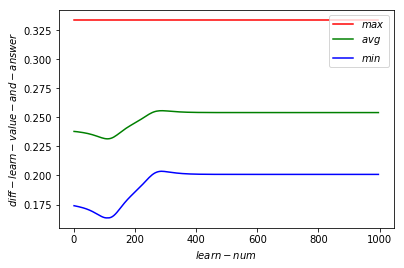

In [271]:
# sotmax Layerを用いたNNモデル
# 多層レイヤー（bitデータ(1を与えるとy20は1を返し、y21は反転を返す）
import numpy as np
% matplotlib inline

from matplotlib import pyplot as plt
from tqdm import tqdm

class Layer:
    
    def __init__(self, m, n): 
        self._rate = 0.1
        self._weight = np.random.rand(m, n) - 0.5  # m行n列を設定(-0.5をすることで-0.5 ~ 0.5の範囲にする)
        self._bias = np.zeros((m, 1))  # m行1列の　0ベクトルを作成してくれている  # バイアスは出力の行
        self._y = None
        self._delta = None
        self._identity = np.identity(m)
        
    def set_state(self, x):
        """入力値を内積"""
        s = (self._weight.dot(x))+1*self._bias
        return s

    def logistic(self, s):
        "シグモイド関数"
        self._y = 1 / (1 + np.exp(-s))
        return self._y

    def softmax(self, s):
        "ソフトマックス関数"
        self._y = np.exp(s - np.max(s)) / np.exp(s - np.max(s)).sum()
        return self._y
                        
    
    def logistic_foward(self, x):
        """logistic順伝播"""
        return self.logistic(self.set_state(x))
    def softmax_foward(self, x):
        """softmax順伝播"""
        return self.softmax(self.set_state(x))
    
    def back_propagation(self, prev_W, prev_delta, t):
        """勾配計算(誤差逆伝播)"""
        if prev_W is not None:
            # deltaを持って入ればパラメータの伝播( ∂E/∂W , ∂E/∂b)
            self._delta = prev_W.T.dot(prev_delta) * self._y  # (V00,01,10,11前回パラメータ) * (∂20,21前回delta) * (y10,y11今回出力)
        else:
            de = self._y - t
            dy = self._y * (np.identity(len(self._y)) - self._y).T  # 一般的な誤差逆伝播の偏微分式(今回はsoftmax対応)
#             dy = self._y * (1 - self._y)  # シグモイドの偏微分
            self._delta = de * dy  # 初回誤差(delta) 
        return self._delta
    
    取得
    def update(self, input_x):
        """パラメーター更新"""
#         self._weight -= self._rate * self._delta * input_x.T  # 入力値(y10を与えている) # self._delta * input_x.T(入力値)
        self._weight -= self._rate * self._delta.dot(self._weight)
        self._bias -= self._rate * self._delta.dot(self._bias)
        return self._y
    
    def error_function(self, y, o):
        
        print("y[0]とo[0]",y[0],o[0])
        print("y[1]とo[1]",y[1],o[1])
        correct = 1/2 * np.power(y[0] - o[0],2)
        opposite = 1/2 * np.power(y[1] - o[1],2) 
        return correct + opposite

if __name__ == '__main__':
    bit_input = np.array([[[1.]],
                          [[0.]],
                          [[1.]],
                          [[1.]],
                          [[0.]]])
    bit_output = np.array([[[1.],
                            [0.]],
                           [[0.],
                            [1.]],
                           [[1.],
                            [0.]],
                           [[1.],
                            [0.]],
                           [[0.],
                            [1.]]])
    
    n1 = Layer(2,1) # １層目 ：1入力値が列、2出力値が行
    n2 = Layer(2,2) # ２層目 ：2入力値が列、2出力値が行
    prev_W = None
    prev_delta = None
    output_x = []
    tmp_y = []
    output_y_max = []
    output_y_avg = []
    output_y_min = []
    learn_num = 1000
    interval = 5
    for i in tqdm(range(0, learn_num)):
        for input_x, anser in zip(bit_input,bit_output):
            n1_myself_y = n1.logistic_foward(input_x)  # 1層目foward
            n2_myself_y = n2.softmax_foward(n1_myself_y)  # 2層目foward
            n2.back_propagation(prev_W, prev_delta, anser)  # 2層目back(1層目の初期値Wとdeltaとanswerを与える)
            n2_prev_W, n2_delta = n2._weight, n2._delta  # 2層目のWとdeltaを取得
            n1.back_propagation(prev_W, prev_delta, anser)  # 1層目へ伝播
            n1_prev_W, n1_delta = n1._weight, n1._delta

            n2.update(n2_prev_W) # 2層目のパラメータの更新(1層目の出力値が入力値)
            n1.update(n1_prev_W) # 1層目のパラメータの更新(初期入力値)
            
            n1_myself_y = n1.logistic_foward(input_x) # 最終的な誤差を計算するために一度foward n1から
            n2_myself_y = n2.softmax_foward(n1_myself_y)  # n2は最後なのでsoftmaxへ
#             print("誤差：", n1.error_function(n2_myself_y, anser))
            diff = n1.error_function(n2_myself_y, anser)
            tmp_y.append(diff)
        if i % interval == 0:
            output_y_max.append(max(tmp_y))
            output_y_avg.append(sum(tmp_y) / len(tmp_y))
            output_y_min.append(min(tmp_y))
            tmp_y = []
            output_x.append(i+1)

    # output
    line_max, line_avg, line_min = plt.plot(
        output_x, output_y_max, 'r-', 
        output_x, output_y_avg, 'g-', 
        output_x, output_y_min, 'b-'
    )
    plt.legend((line_max, line_avg, line_min), ('$max$', '$avg$', '$min$'))
    plt.xlabel('$learn-num$')
    plt.ylabel('$diff-learn-value-and-answer$')
    plt.show()